In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
data = np.transpose(np.loadtxt("peakpositioner.txt",skiprows=1))
thetas = data[0]
peakpos = data[1]

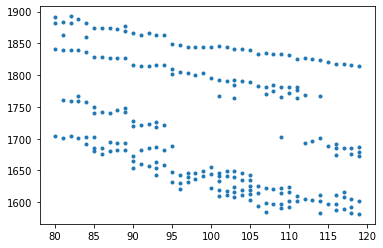

In [10]:
plt.plot(thetas,peakpos, '.')